<a href="https://colab.research.google.com/github/guidomoor/FEA-ML/blob/main/Linear_Elastic_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Netowrk to predict Stresses, from strain states

In [335]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [336]:
 #Create a model
 class Model(nn.Module):
  def __init__(self, in_features=3, h1=16, h2=12, h3= 8, out_features=3):
    super().__init__()
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, h3)
    self.out = nn.Linear(h3, out_features)

  #Forward pass: (pushing the information forward through the layers)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.out(x)
    return x

In [337]:
torch.manual_seed(42)
model = Model()

In [338]:
from google.colab import files

# Upload a file
uploaded = files.upload()

# Check the uploaded files
for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')
    my_df = pd.read_csv(filename, header=None)  # Read the CSV file into a DataFrame

In [339]:
# DF has 17 columns:
# INPUT: 3 strains (E)
# OUTPUT: 3x3 D components
X = my_df.iloc[:, :3]  # Select the first 3 columns, E
y = my_df.iloc[:, 3:]   # Select the last 3 columns, S
#convert to numpy arrays
#Data used in the NN
X = X.values
y = y.values

In [340]:
from sklearn.model_selection import train_test_split

# Combine inputs and outputs into a single array for proper splitting
data = np.hstack((X, y))

# Ensure data is unique
unique_data = np.unique(data, axis=0)

# Split the unique data into training and validation sets
train_data, val_data = train_test_split(unique_data, test_size=0.1, random_state=42)

# Separate inputs (X) and outputs (y) for training and validation
X_train, y_train = train_data[:, :3], train_data[:, 3:]
X_test, y_test = val_data[:, :3], val_data[:, 3:]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [341]:
#Set the criterion of model to measure the error

criterion = nn.MSELoss()  # Use MSE loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [342]:
#Train the model:
# Epochs: (one run through all the training data in the network)
epochs = 15000
losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for i in range(epochs):
    model.train()
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.detach().numpy())

    # Calculate accuracy for training and validation
    with torch.no_grad():
        model.eval()
        train_accuracy = 1 - torch.mean(torch.abs(y_pred - y_train))
        val_pred = model(X_test)
        val_loss = criterion(val_pred, y_test)
        val_losses.append(val_loss.detach().numpy())
        val_accuracy = 1 - torch.mean(torch.abs(val_pred - y_test))
        train_accuracies.append(train_accuracy.item())
        val_accuracies.append(val_accuracy.item())

    # Print the losses (for tracking training progress)
    if i % 10 == 0:
        print(f"Epoch: {i} Loss: {loss}")

    # Backpropagation: update the model's weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 Loss: 0.055387187749147415
Epoch: 10 Loss: 0.05430525168776512
Epoch: 20 Loss: 0.053248729556798935
Epoch: 30 Loss: 0.052217960357666016
Epoch: 40 Loss: 0.05121105909347534
Epoch: 50 Loss: 0.05022536218166351
Epoch: 60 Loss: 0.049258846789598465
Epoch: 70 Loss: 0.0483107827603817
Epoch: 80 Loss: 0.0473802350461483
Epoch: 90 Loss: 0.04646627604961395
Epoch: 100 Loss: 0.04556818678975105
Epoch: 110 Loss: 0.04468566179275513
Epoch: 120 Loss: 0.04381859675049782
Epoch: 130 Loss: 0.04296763986349106
Epoch: 140 Loss: 0.04213353246450424
Epoch: 150 Loss: 0.04131704196333885
Epoch: 160 Loss: 0.04051729664206505
Epoch: 170 Loss: 0.03973230719566345
Epoch: 180 Loss: 0.03896118700504303
Epoch: 190 Loss: 0.038203656673431396
Epoch: 200 Loss: 0.037459343671798706
Epoch: 210 Loss: 0.03672780469059944
Epoch: 220 Loss: 0.03600980341434479
Epoch: 230 Loss: 0.035305991768836975
Epoch: 240 Loss: 0.03461682051420212
Epoch: 250 Loss: 0.033943675458431244
Epoch: 260 Loss: 0.03329571709036827
Epoch:

Text(0.5, 0, 'Epoch')

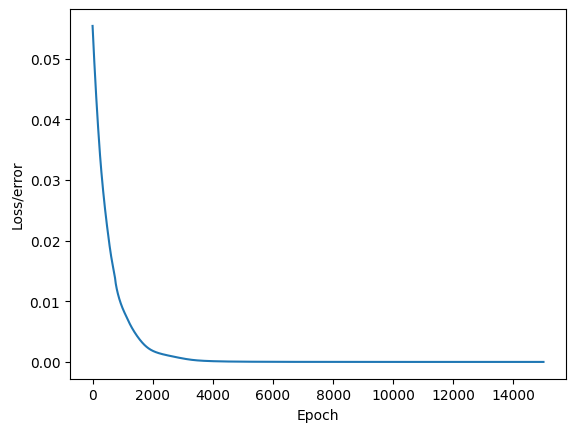

In [343]:
#Plot Loss
plt.plot(range(epochs), losses)
plt.ylabel('Loss/error')
plt.xlabel('Epoch')

In [344]:
# Set the model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Get predictions
    y_preds = model(X_test)

    # Calculate Mean Absolute Error (MAE)
    mae = torch.mean(torch.abs(y_preds - y_test))
    print(f'MAE: {mae.item():.4f}')

    # Calculate Mean Squared Error (MSE)
    mse = torch.mean((y_preds - y_test) ** 2)
    print(f'MSE: {mse.item():.4f}')

    # Calculate R-squared
    ss_total = torch.sum((y_test - torch.mean(y_test)) ** 2)
    ss_residual = torch.sum((y_test - y_preds) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    print(f'R-squared: {r_squared.item():.4f}')

MAE: 0.0000
MSE: 0.0000
R-squared: 1.0000


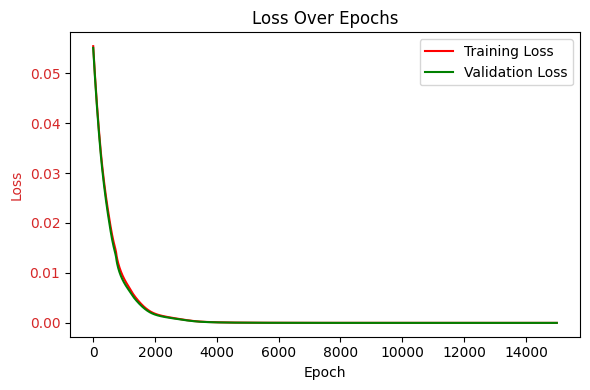

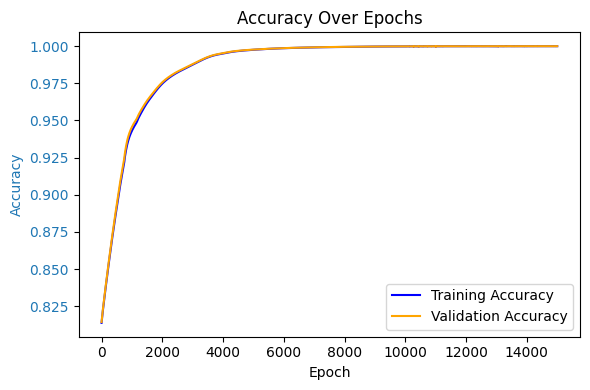

In [345]:
# Plot Loss
fig1, ax1 = plt.subplots(figsize=(6, 4))  # Create a rectangular figure for Loss
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(epochs), losses, label='Training Loss', color='red')
ax1.plot(range(epochs), val_losses, label='Validation Loss', color='green')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper right')
plt.title('Loss Over Epochs')
fig1.tight_layout()  # Adjust layout
plt.show()

# Plot Accuracy
fig2, ax2 = plt.subplots(figsize=(6, 4))  # Create a rectangular figure for Accuracy
color = 'tab:blue'
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(range(epochs), train_accuracies, label='Training Accuracy', color='blue')
ax2.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='orange')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='lower right')
plt.title('Accuracy Over Epochs')
fig2.tight_layout()  # Adjust layout
plt.show()

In [346]:
import torch

# Define the new input tensor
new_input = torch.tensor([[0.0905399000000000,	0.0389431570000000,	0.136283070000000]])

# Normalization parameters
#input_min = -0.790252500000000
input_max = 0.807000000000000

#output_min = -52470
output_max = 72630

# Normalize the new input
new_input_normalized = new_input/input_max

# Print the normalized input
print(f'Normalized Input: {new_input_normalized}')

# Disable gradient calculation
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode

    # Perform prediction on normalized input
    y_pred = model(new_input_normalized)

    # Denormalize the prediction to get the real-world values
    y_pred_real = y_pred * output_max

    # Print the denormalized prediction
    print(f'Denormalized Prediction: {y_pred_real}')

    # Optionally, print the normalized prediction
    print(f'Normalized Prediction: {y_pred}')



Normalized Input: tensor([[0.1122, 0.0483, 0.1689]])
Denormalized Prediction: tensor([[10111.0693,  6539.9126,  4717.0752]])
Normalized Prediction: tensor([[0.1392, 0.0900, 0.0649]])
